In [2]:
import pymc as pm
import pymc3 as pm3
import theano as th
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as pl

th.config.compute_test_value = 'off'

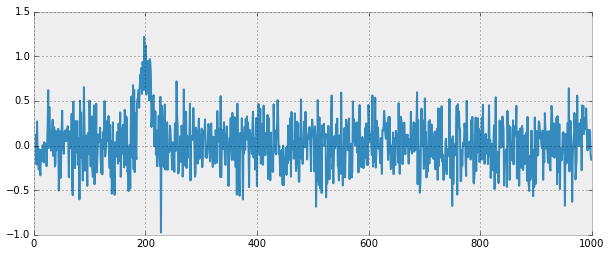

In [14]:
MU = 200
SIGMA = 10
NOISE = 0.25
SAMPLES = 8000
BURN = 2000

X = np.arange(1000)
Y = np.exp(-(X - MU)**2 / (2 * SIGMA**2)) + NOISE * np.random.randn(len(X))
pl.plot(X, Y)
pl.show()

### PyMC2

In [12]:
mu = pm.Uniform('mu', lower=0, upper=len(X))
sigma = pm.Uniform('sigma', lower=1, upper=25)

@pm.deterministic
def gaussian(x=X, mu=mu, sigma=sigma):
     return np.exp(-(x - mu)**2 / (2 * sigma**2))

noise = pm.Uniform('noise', lower=0, upper=1)
obs = pm.Normal('obs', mu=gaussian, tau=1/noise**2, observed=True,
                value=Y)

 [-----------------100%-----------------] 10000 of 10000 complete in 3.6 sec

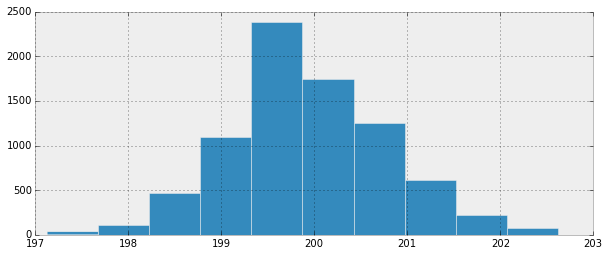

In [15]:
model = pm.Model([mu, sigma, noise, obs])
mcmc = pm.MCMC(model)
mcmc.sample(SAMPLES + BURN, BURN)

pl.hist(mcmc.trace('mu')[:])
pl.show()

### PyMC3

In [18]:
with pm3.Model() as model:
    mu = pm3.Uniform('mu', lower=0, upper=len(X))
    sigma = pm3.Uniform('sigma', lower=1, upper=25)
    gaussian = T.exp(-(X - mu)**2 / (2 * sigma**2))
    noise = pm3.Uniform('noise', lower=0, upper=1)
    obs = pm3.Normal('obs', gaussian, sd=NOISE, observed=Y)

 [-----------------100%-----------------] 10000 of 10000 complete in 6.3 sec

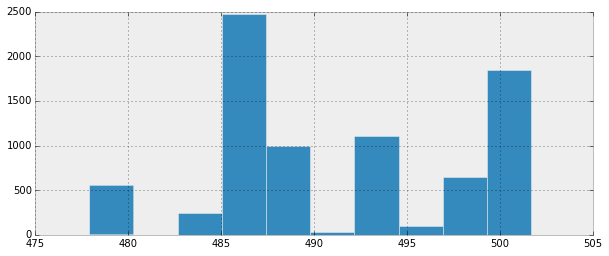

In [21]:
with model:
    step = pm3.Metropolis()
    trace = pm3.sample(BURN + SAMPLES, step, progressbar=True)
    
pl.hist(trace.get_values('mu', combine=True, burn=BURN))
pl.show()